# RegTech Session: Transaction monitoring 

This session present an example focusing on transaction monitoring on an abstract level. We cover the following topis:

* Model of a transaction system
* Classical transaction schemes.
* Detection based on node-properties
* Detection based on transaction structures
* Limitations and Challenges


In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

from simulator import Simulator
from behaviors import random_behavior, layering, round_tripping

### Examples of transaction-based crime

Transaction-based crime is the core of compliance monitoring. In general, the aim of this crime is to pass funds or goods originating from illegal behavior. Examples of transaction-based crime include:

- Money laundering: 
- Sanction evasion:
- Credit card fraud:
- ...

### Research Question

Consider a set of users, some of which control multiple accounts, passing transactions around. Some transactions are compliant and some are non-compliant. How do we tell compliant from non-compliant ones?

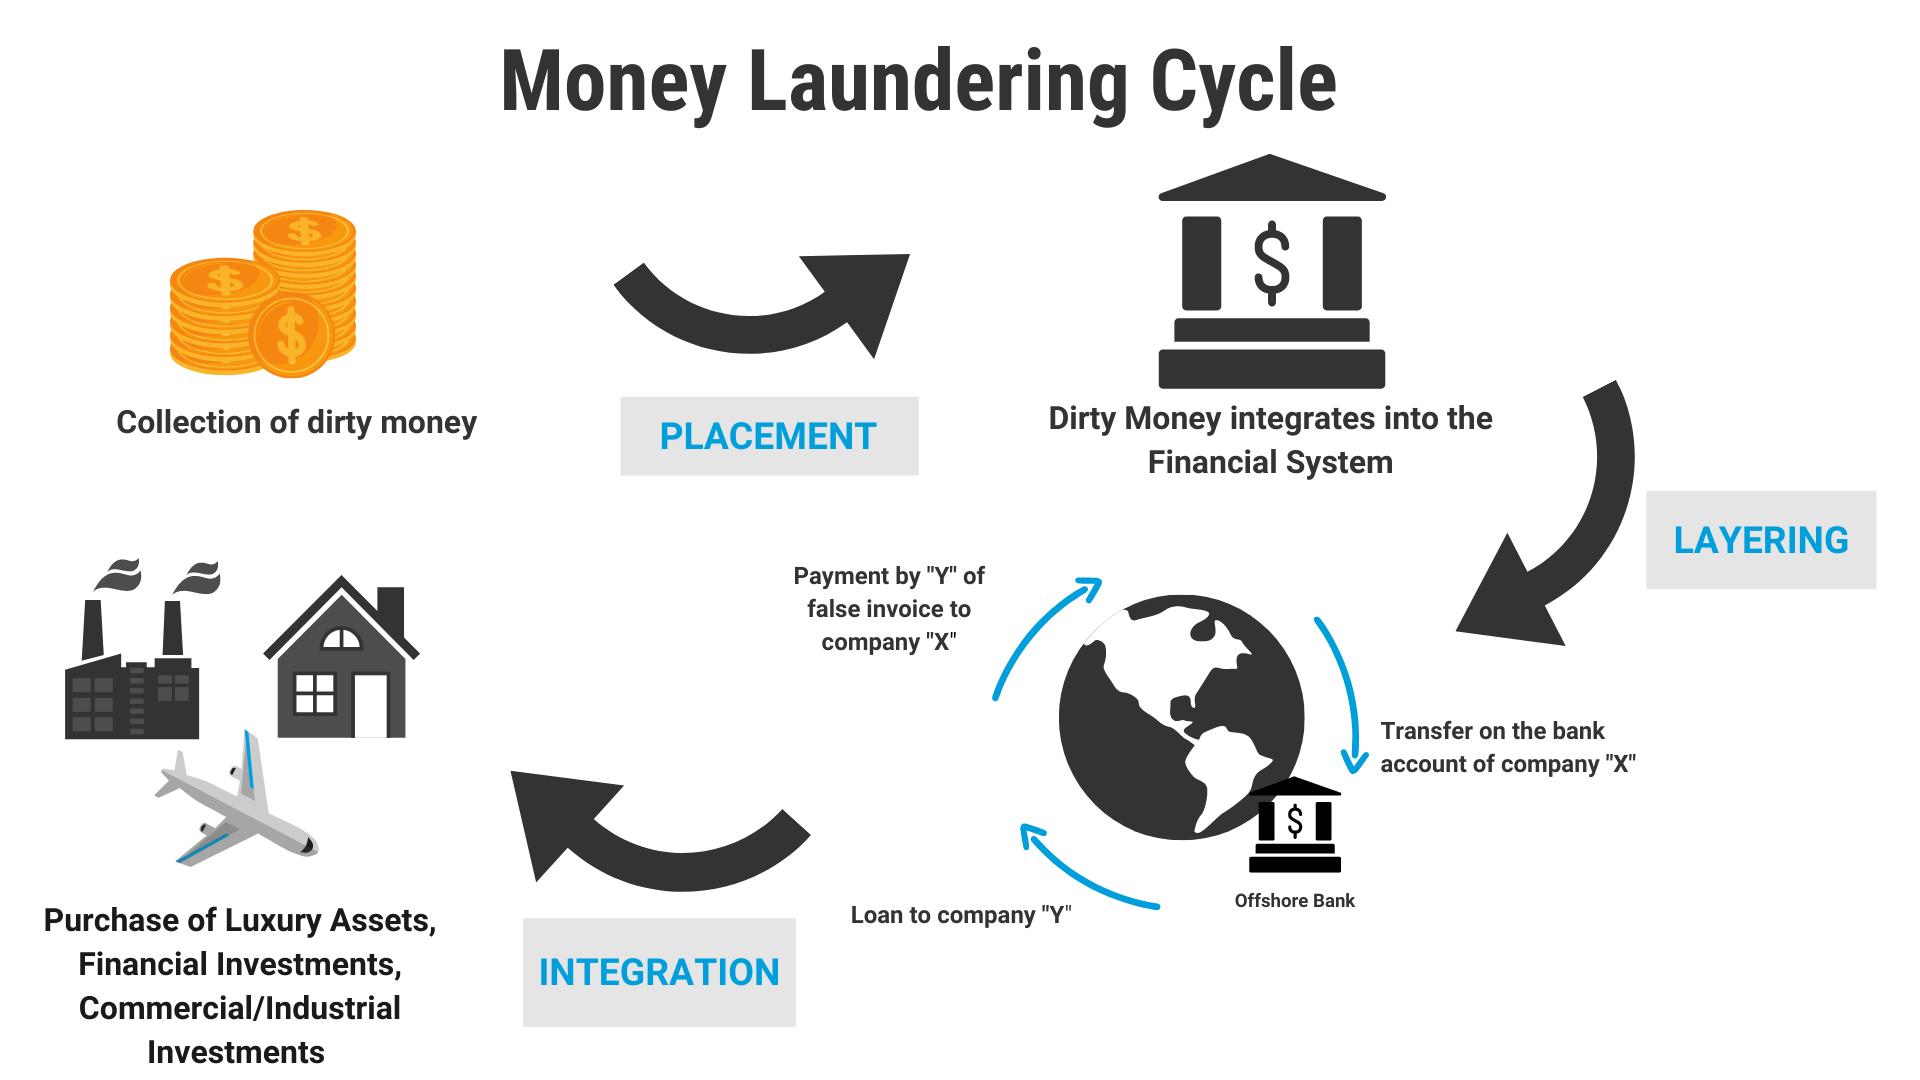

Typical life-cycle of money laundering

### Abstraction of behavior

Transaction patterns differ from one case to another. However, certain different criminals can have the same ideas on how to pass illicitly obtained funds or goods. For example, layering is a relatively basic approach, as illustrated bellow 

## Layering and Round Tripping

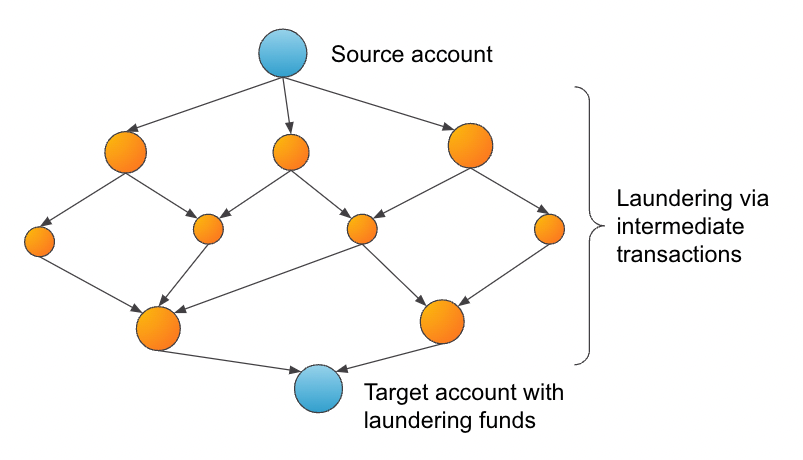

layering of funds to make detection more difficult

More sophisticated approach is **round tripping**. The basic idea is to pass funds between intermediate addresses multiple times and randomly, as if standard economic activity was conducted. After multiple "rounds", the funds are passed to the target account, where the integration process begins.

In [3]:
#set up agents

#non-compliant agents performing layering
N_lr_intermediate_accounts = 5
lr_accounts = {
    'source_account': 'SL',
    'intermediate_accounts': ['IL' + str(i) for i in range(N_lr_intermediate_accounts)],
    'target_account': 'TL'
}
lr = layering(lr_accounts)

#non-compliant agents performing round tripping
N_rt_source_accounts, N_rt_intermediate_accounts, N_rt_target_accounts = 10, 25, 4
rt_accounts = {
    'source_accounts': ['S' + str(i) for i in range(N_rt_source_accounts)],
    'intermediate_accounts': ['I' + str(i) for i in range(N_rt_intermediate_accounts)],
    'target_accounts': ['T' + str(i) for i in range(N_rt_target_accounts)]
}
rt = round_tripping(rt_accounts)

#all acounts
N_ra = 500
compliant_accounts = ['C' + str(i) for i in range(N_ra)]
noncompliant_accounts = lr.noncompliant_accounts + rt.noncompliant_accounts
allAccounts = compliant_accounts + noncompliant_accounts

#random compliant agents
rb = random_behavior(allAccounts)

In [4]:
df_rb = rb.generate(k = 30000)
df_lr = lr.generate(amount_per_send = 9999)
df_rt = rt.generate(max_intermediate_transactions = 30, capital=5*10**6)

df = pd.concat([df_rb, df_lr, df_rt])
df = df.sort_values('time')
print(df.shape)
df.head(10)

(38645, 4)


,source,target,amount,time
1229,S1,I23,7058.20,2025-03-01 08:00:00
1100,S3,I13,16173.64,2025-03-01 08:00:00
3731,S2,I20,7600.14,2025-03-01 08:00:00
2594,S0,I13,4677.50,2025-03-01 08:00:00
7177,S5,I12,16523.58,2025-03-01 08:00:00
5831,S3,I2,13038.64,2025-03-01 08:00:00
8239,I3,I4,5956.95,2025-03-01 08:00:00
8238,S7,I3,5956.95,2025-03-01 08:00:00
4040,S0,I21,2481.40,2025-03-01 08:00:00
4041,I21,I7,2481.40,2025-03-01 08:00:00


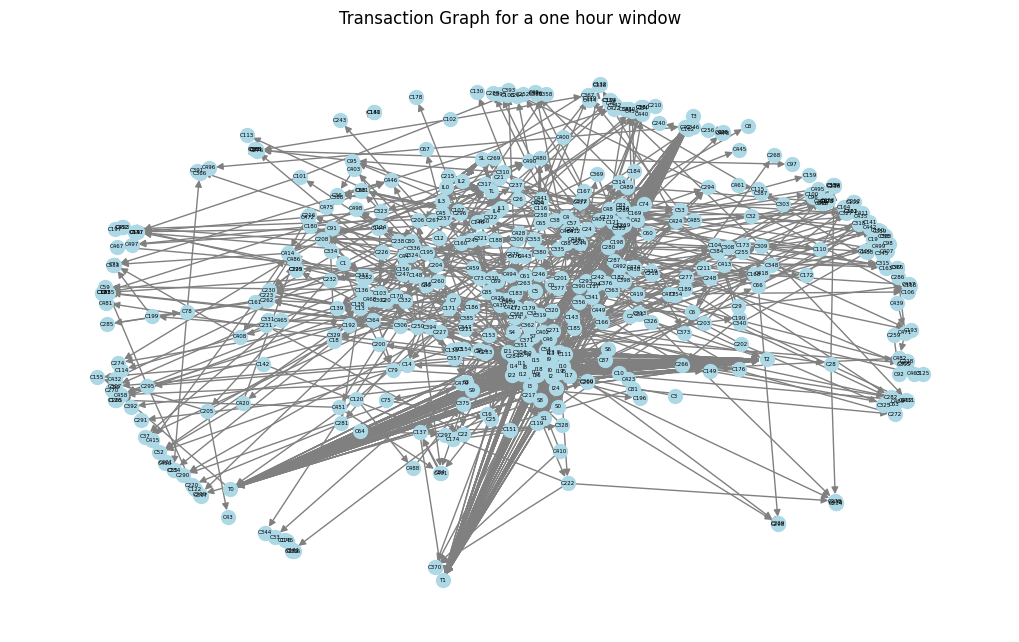

In [ ]:
tmp = df.loc[df['time'] < datetime(2025, 3, 1, 9, 0, 0)]
rb.plotTransactionGraph(tmp, edgeLables=False, title="Transaction Graph for a one hour window") 

## Detection

### Rule-based approach

<Axes: >

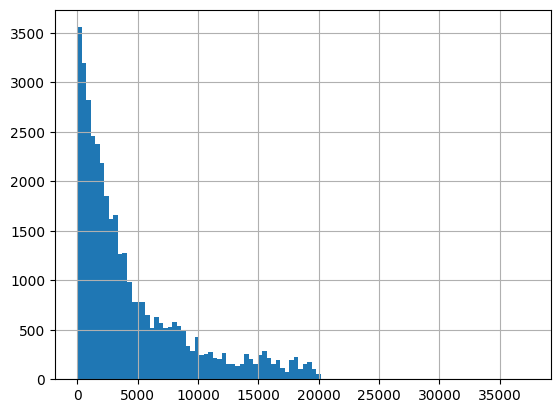

In [6]:
df['amount'].hist(bins = 100)

In [14]:
from collections import Counter

#identifying all transactions with suspicious amount
def getSuspects(df, lower_th = 9900, upper_th = 10000):
    df_suspects = df.loc[(df['amount'] > lower_th) & (df['amount'] < upper_th)] 
    suspects = df_suspects['source'].to_list() + df_suspects['target'].to_list()

    #counting how many times the account engaged in a transaction that triggered a rule match
    suspects = pd.Series({id: count/len(suspects) for id, count in Counter(suspects).items()}).to_frame('Risk')
    #suspects.sort_values('Risk', ascending=False)
    return suspects

#setting a threshold by which we define what frequency of matches is significant
def thresholdSuspects(suspects, threshold):
    return list(suspects.loc[suspects['Risk'] > threshold].index)

suspects = getSuspects(df)
high_risk_suspects = thresholdSuspects(suspects, 0.05)

In [15]:
def getConfusionTable(noncompliant_prediction, compliant_prediction, compliant_accounts, noncompliant_accounts):
    TP = len(set(noncompliant_prediction).intersection(noncompliant_accounts))
    TN = len(set(compliant_prediction).intersection(compliant_accounts))
    FP = len(set(noncompliant_prediction).intersection(compliant_accounts))
    FN = len(set(compliant_prediction).intersection(noncompliant_accounts))
    return {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
    
not_suspects = list((set(allAccounts) - set(high_risk_suspects)))

getConfusionTable(high_risk_suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 7, 'TN': 500, 'FP': 0, 'FN': 39}

### Anomaly detection based on local features

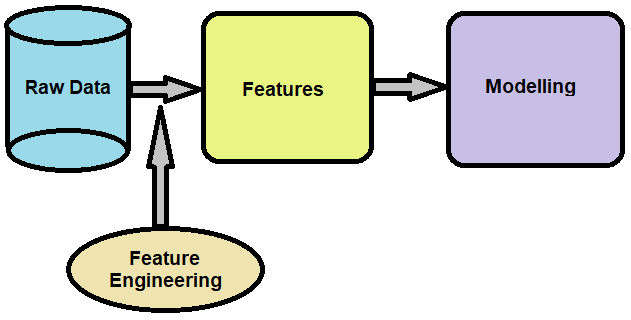

In [ ]:
import networkx as nx

class feature_factory():
    
    def __init__(self, df):
        self.df = df
        self.allAccounts = df['source'].to_list() + df['target'].to_list()
        self.G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['amount', 'time'], create_using=nx.MultiDiGraph)

    def total_transactions(self):
        #for each account: a total number of transactions that
        return dict(self.G.degree())

    def avg_amount_sent_per_transaction(self):
        #for each account: average amount sent per time unit
        return {id: attr['amount'] for id, attr in df.groupby(['source'])[['amount']].mean().to_dict(orient='index').items()}


    def avg_amount_received_per_transaction(self):
        #for each account: average amount received per time unit
        return {id: attr['amount'] for id, attr in df.groupby(['target'])[['amount']].mean().to_dict(orient='index').items()}
    
    def unique_adjacency(self):
        #for each account: integer counts of accounts the received or sent a transaction
        unique_outdeg = {}
        for node, edges in self.G.adjacency():
            unique_outdeg[node] = len(edges.keys())
        return unique_outdeg
    
    def good_old_round_values_rule(self):
        #for each account: a boolean values indicating if our rule defined in previous section is true
        suspects = getSuspects(self.df)
        high_risk_suspects = thresholdSuspects(suspects, 0.1)
        return  {account: (account in high_risk_suspects) for account in self.allAccounts}

        

In [17]:
features = feature_factory(df)

f0 = features.total_transactions()
f1 = features.unique_adjacency()
f2 = features.good_old_round_values_rule()
f3 = features.avg_amount_sent_per_transaction()
f4 = features.avg_amount_received_per_transaction()

df_featurized = pd.DataFrame.from_records([f0,f1,f2,f3,f4]).transpose()
df_featurized.head(10)

,0,1,2,3,4
S1,168,67,False,6728.391455,2820.965517
I23,802,91,False,8221.292924,8297.813215
S3,157,72,False,6049.691458,2530.360656
I13,717,71,False,9269.743697,9162.234722
S2,138,64,False,5908.060952,2597.851852
I20,751,86,False,8597.723526,8699.859677
S0,146,68,False,5914.808396,3123.15
S5,149,70,False,6232.726887,3769.302326
I12,762,78,False,8658.602016,8523.381714
I2,796,81,False,9294.658271,9224.089798


#### Normalization

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(df_featurized)
x = pd.DataFrame(data)

#### Clustering: Isolation Forest

**Isolation Forest** is an unsupervised machine learning algorithm designed for anomaly (outlier) detection. It works by randomly partitioning data using binary trees, called Isolation Trees (iTrees). The key idea is that anomalies are rare and different, so they can be isolated with fewer random splits compared to normal points.

In [14]:
#!pip install scikit-learn

In [19]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(df_featurized)
predictions = clf.predict(df_featurized)

In [20]:
suspects = []
not_suspects = []
for i, account in enumerate(df_featurized.index):
    if predictions[i] == -1:
        suspects.append(account)
    else:
        not_suspects.append(account)

getConfusionTable(suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 46, 'TN': 487, 'FP': 13, 'FN': 0}

In [21]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(2)
#Transform the data to 2d
df_components = pca.fit_transform(df_featurized)

#learn isolation forest model from 2d data
clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(df_components)
predictions = clf.predict(df_components)

df_results = df_featurized.copy()
df_results['prediction'] = predictions
types = []
for account in df_results.index:
    if account in lr.noncompliant_accounts:
        types.append('layering')
    elif account in rt.noncompliant_accounts:
        types.append('round_tripping')
    else:
        types.append('compliant')

df_results['behavior'] = types
df_results.head(15)

,0,1,2,3,4,prediction,behavior
S1,168,67,False,6728.391455,2820.965517,-1,round_tripping
I23,802,91,False,8221.292924,8297.813215,-1,round_tripping
S3,157,72,False,6049.691458,2530.360656,-1,round_tripping
I13,717,71,False,9269.743697,9162.234722,-1,round_tripping
S2,138,64,False,5908.060952,2597.851852,-1,round_tripping
I20,751,86,False,8597.723526,8699.859677,-1,round_tripping
S0,146,68,False,5914.808396,3123.15,-1,round_tripping
S5,149,70,False,6232.726887,3769.302326,-1,round_tripping
I12,762,78,False,8658.602016,8523.381714,-1,round_tripping
I2,796,81,False,9294.658271,9224.089798,-1,round_tripping


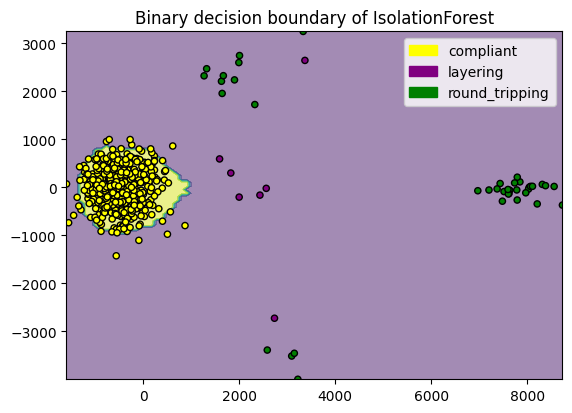

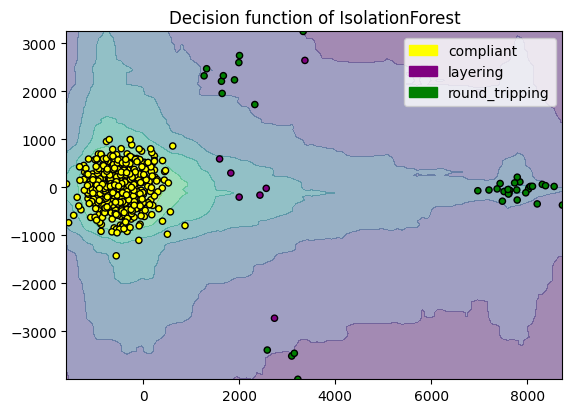

In [22]:
import matplotlib.patches as mpatches
d = {'compliant': 'yellow', 'layering': 'purple', 'round_tripping': 'green'}
for rm in ["predict", "decision_function"]:
    disp = DecisionBoundaryDisplay.from_estimator(clf, df_components, response_method=rm, alpha=0.5,)
    disp.ax_.scatter(df_components[:, 0], df_components[:, 1], c=list(map(d.get, df_results['behavior'])), s=20, edgecolor="k")
    if rm == 'predict': disp.ax_.set_title("Binary decision boundary of IsolationForest")
    if rm == 'decision_function': disp.ax_.set_title("Decision function of IsolationForest")
    plt.axis("square")
    plt.legend(handles = [mpatches.Patch(color=c, label=l) for l,c in d.items()])
    plt.ylim(min(df_components[:, 1]), max(df_components[:, 1]))
plt.show()

Lets look at what types of behavior were easier to identify

In [23]:
suspects = df_results.loc[(df_results['prediction'] == -1) & (df_results['behavior'] != 'round_tripping')].index.to_list()
not_suspects = df_results.loc[(df_results['prediction'] == 1) & (df_results['behavior'] != 'round_tripping')].index.to_list() 

getConfusionTable(suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 7, 'TN': 477, 'FP': 23, 'FN': 0}

In [24]:
suspects = df_results.loc[(df_results['prediction'] == -1) & (df_results['behavior'] != 'layering')].index.to_list()
not_suspects = df_results.loc[(df_results['prediction'] == 1) & (df_results['behavior'] != 'layering')].index.to_list() 

getConfusionTable(suspects, not_suspects, compliant_accounts, noncompliant_accounts)

{'TP': 39, 'TN': 477, 'FP': 23, 'FN': 0}

### Clustering based on structural knowledge

#### converting Multi-graph

In [25]:
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['amount', 'time'], create_using=nx.MultiDiGraph)

#G_simple = nx.DiGraph()
#for u, v, data in G.edges(data=True):
#    if G_simple.has_edge(u, v):
#        G_simple[u][v]['weight'] += data['amount']  # Sum weights
#    else:
#        G_simple.add_edge(u, v, weight=data['amount'])

### Louvain community clustering algorithm

The Louvain method is a popular algorithm for detecting communities (clusters) in large networks. Communities are groups of nodes that are more densely connected to each other than to the rest of the network

In [26]:
communities = nx.community.louvain_communities(G, seed=123)

In [27]:
community_results = []
for i, com in enumerate(communities):
    ca_intersection_size = len(com.intersection(set(compliant_accounts)))
    lr_intersection_size = len(com.intersection(set(lr.noncompliant_accounts)))
    rt_intersection_size = len(com.intersection(set(rt.noncompliant_accounts)))
    community_results.append({'compliant accounts':ca_intersection_size, 'layering accounts':lr_intersection_size, 'round-tripping accounts':rt_intersection_size})

community_results = pd.DataFrame(community_results)

community_results.index.rename('community_id', inplace=True)

community_results.style.set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{'selector': 'th', 'props': [('font-size', '14px')]}]) \
    .background_gradient(cmap="Blues") 

,compliant accounts,layering accounts,round-tripping accounts
community_id,,,
0,0,0,39
1,0,7,0
2,500,0,0


Clustering algorithms applied on the **graph level** allow us to see the "big picture", thus incorporate **global** information about the behavioral patterns. However, local features can provide important information, therefore optimally one would prefer to use methods that include local features with information about the graph structure; such as graph neural networks.

In [23]:
#!pip install python-louvain
#!pip install cdlib